<h1 align="center"><font size="7" face="arial" color="#73ACCD">Hands-On: Surface-based simulation with stimulus</font></h1>
<h2 align="center"><font size="6" face="arial" color="#73ACCD">Generate a stimulus propagation on the cortical surface</font></h2>

<br>
<h2 align="center"><font size="5" face="arial">March 10, 2020</font></h2>
<h3 align="center"><span style="font-weight:normal"><font size="5" face="arial">Jil Meier &#38; Paul Triebkorn</font></span></h3>
<h3 align="center"><span style="font-weight:normal"><font size="3" face="arial">Charité Universitätsmedizin Berlin, Dept of Neurol, Brain Simulation Section, Berlin, Germany</font></span></h3>

<h3 align="center"><span style="font-weight:normal"><font size="3" face="arial"><a href="mailto:jil-mona&#38;.meier@charite.de">jil-mona.meier@charite.de</a>, <a href="mailto:jan-paul&#38;.triebkorn@charite.de">jan-paul.triebkorn@charite.de</a></font></span></h3>

In [ ]:
! pip install -U tvb-library

In [ ]:
!pip uninstall -y tvb-data
!wget https://zenodo.org/record/3688773/files/tvb-data.zip?download=1 -O $HOME/tvb_data.zip; \
    rm -rf $HOME/tvb_data; mkdir $HOME/tvb_data; unzip $HOME/tvb_data.zip -d $HOME/tvb_data; rm $HOME/tvb_data.zip; \
    cd $HOME/tvb_data; python setup.py develop

In [1]:
from mpl_toolkits.mplot3d import Axes3D
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Surface-based simulation and stimulus tutorial

This tutorial will have 2 parts, we will start with creating a surface-based simulation in Part A and then introduce a stimulus to a region-based simulation (for faster computation) in Part B.

# Part A: Your first surface-based simulation

This extends the basic region simulation, covered in the region simulation tutorial, to include the folded cortical surface to the anatomical structure on which the simulation is based, if you haven't already looked at that tutorial you probably should do that now as here we only really discuss in detail the extra things that are specific to a simulation on the cortical surface.

In addition to the components discussed for a region simulation here we introduce one new major component, that is:

1. *Cortex*, the primary component of which is a mesh surface defining a 2d representation of the convoluted cortical surface embedded in 3d space. This object includes a range of ancillary information and methods required for using it in simulations. 

Setup
-----

Here we'll skip quickly over the configuration that was covered in previous tutorials. 

In [2]:
#Import a bunch of stuff to ease command line usage
from tvb.simulator.lab import * 
import numpy as numpy

In [3]:
#Initialise a Model, Coupling, and Connectivity.
oscillator = models.Generic2dOscillator()
white_matter = connectivity.Connectivity.from_file()
white_matter.speed = numpy.array([4.0])

white_matter_coupling = coupling.Linear(a=numpy.array(0.014))

#Initialise an Integrator
heunint = integrators.HeunDeterministic(dt=2**-4)

WARNING  File 'hemispheres' not found in ZIP.


*Surface*
-----------

Now to the surface itself. The main two attributes of a surface that we'll typically want to modify are
the *LocalConnectivity*, which is a function describing the drop-off in connectivity with distance (in 
its simplest form, think of a truncated Gaussian relative to every vertex of the surface), and the 
*coupling_strength* which is just a weighting of the *LocalConnectivity* function, which potentially can
be specified independently for every vertex (node on the cortical surface).

Here, we'll use the default *LocalConnectivity* function, and scale it appropriately based on the *Model*
*Cortex* and *Connectivity* we'll be using. Unfortunately, for the time being there is not an automated way 
to determine the appropriate coupling strength given the Models selection, etc, so it is necessary to get 
a feeling for a specific system (Models, structure, etc) by experimenting a bit -- we are working toward
tools that will ease this phase of model development.

In [4]:
#Initialise a surface
cortical_surface = surfaces.CorticalSurface.from_file()
cortical_surface.configure()
region_mapping = region_mapping.RegionMapping.from_file()
region_mapping.surface=cortical_surface
default_cortex = cortex.Cortex.from_file()
default_cortex.region_mapping_data = region_mapping
default_cortex.coupling_strength = numpy.array([2**-10])

In [5]:
default_cortex.configure()

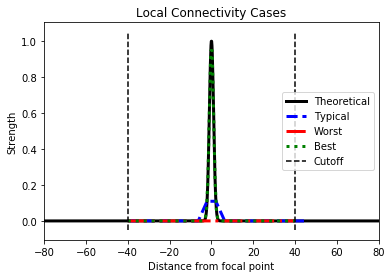

In [6]:
plot_local_connectivity(default_cortex)

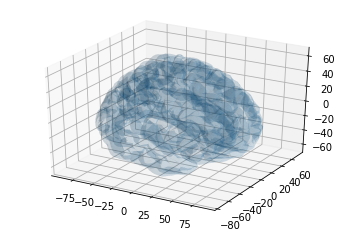

In [7]:
# plot the cortical surface 
figure()
ax = subplot(111, projection='3d')
x, y, z = default_cortex.vertices.T
ax.plot_trisurf(x, y, z, triangles=default_cortex.triangles, alpha=0.1, \
                edgecolor='none')
show()

*Monitors*
-----------

The new  *Monitor* that we will use here is called *SpatialAverage*, this *Monitor* will, unsurprisingly, average over the space
(nodes) of the simulation. In the case of region level simulations we already have a situation of a relatively small number
of nodes, with each one representing a fairly large chunk of brain. In surface simulations on the other hand we can easily
have tens of thousands of nodes, and reducing this by averaging over sensible collections of these nodes can be valuable. 
The basic mechanism is general, in the sense that the nodes can be broken up into any non-overlapping, complete set of sets
-- said another way, each node can only be counted in one collection and all nodes must be in one collection. As a concrete 
example, even in surface simulations information regarding a break up into regions exists, and this breakup, where each 
cortical mesh node belongs to one and only one region can be used to define the spatial average. In fact this is the default 
behaviour of the *SpatialAverage* monitor when applied to a surface simulation, that is it averages over nodes and returns
region based time-series.

Here, we'll once again rely on TVB's defaults, where the default *SpatialAverage* monitor will return region level time-series.

In [11]:
#Initialise some Monitors with period in physical time
mon_savg = 
# load the default region mapping
# rm = region_mapping.RegionMapping(load_default=True)
#Bundle them
what_to_watch = mon_savg
what_to_watch

,value
Type,SpatialAverage
default_mask,'hemispheres'
gid,UUID('c6c5e33c-c431-4e7c-9580-b3ad9ec2949a')
period,0.25
spatial_mask,None
title,SpatialAverage gid: c6c5e33c-c431-4e7c-9580-b3ad9ec2949a
variables_of_interest,None


Simulate
---------

We can then configure and run the *Simulator* as in a region based simulation.

NOTE: in this case the configuration needs to calculate the *LocalConnectivity* for the cortical surface, which can take a minute or two.

In [21]:
#Initialise Simulator -- Model, Connectivity, Integrator, Monitors, and surface.
sim = simulator.Simulator(model = oscillator, connectivity = white_matter,
                          coupling = white_matter_coupling, 
                          integrator = heunint, monitors = (monitors.SpatialAverage(period=2**-2),),
                          simulation_length=200,
                          surface = default_cortex)

sim.configure()

WARNING  Memory estimate exceeds total available RAM.


,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: c611afc4-54f0-444d-9f02-81a7f6991e0c
coupling,Linear gid: 5b36f61d-76ee-4215-8e71-c9cd8f8caf54
gid,UUID('0fd692fb-2e9f-4ec1-b42f-5f0218e36fb7')
initial_conditions,None
integrator,HeunDeterministic gid: 01c4b38f-11b8-4e85-b49f-814792735fa5
model,Generic2dOscillator gid: c27cf0a5-f40b-4c70-b3d7-3e89f1a67c14
monitors,"(,)"
simulation_length,200.0


In [22]:
(savg_time, savg_data),  = sim.run()

Pretty Pictures
----------------

And finally, we can look at the results of our simulation in terms of time-series as we have before:

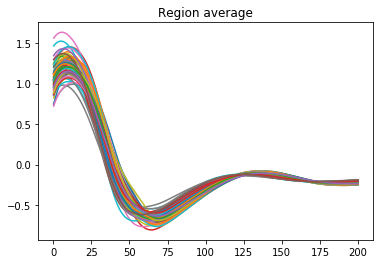

In [23]:
#Make the lists numpy.arrays for easier use.
SAVG = numpy.array(savg_data)

#Plot region averaged time series
figure(1)
plot(savg_time, SAVG[:, 0, :, 0])
title("Region average")
show()

# Part B: Your first stimulus 
In the following, we will first reload everything we need for the region-based simulation and then create a stimulus which we will add to this simulation. Later, we will plot the results of the spatio-temporal propagation of this stimulus on the surface brain.

## Define a stimulus
Because a surface-based simulation takes too long to compute for today, we focus on the region level again and introduce a stimulus there.
Now we will define a stimulus as a Pulse Train.
Load the default connectivity matrix again.

In [24]:
white_matter = connectivity.Connectivity.from_file()
white_matter.speed = numpy.array([4.0])

WARNING  File 'hemispheres' not found in ZIP.


## Spatial pattern of the stimulus

We'll begin by selecting nodes and defining the weighting
of the stimuli coming into those nodes, to show what the basic process looks like.

In [25]:
#Define the stimulus
weighting = numpy.zeros((76, ))
#in case you later want to play with introducing stimuli simultaneously at multiple regions
#weighting[[14, 52, 11, 49]] = 0.1

weighting[[17]] = 0.1

## Temporal profile of the stimulus

We now need to define the temporal profile. This is done by selecting
an equation and setting its parameters as desired. Here, we will just select a standard Pulse train with a length of 50 ms, an onset at 1500 ms and a repition every 1000 ms.

An important thing to note is that, the time defined for the stimuli is
relative to a call of the Simulator. That is, if you run a simulation for 
100ms, and then run the same simulator for a further 100ms (note: continuation
of this sort is discussed in another tutorial) then you'll end up with the
same stimuli repeated 

In [26]:
eqn_t = equations.PulseTrain()
eqn_t.parameters['onset'] = 1.5e3 # ms
eqn_t.parameters['T'] = 1000.0
eqn_t.parameters['tau'] = 50.0

Now we need to combine these spatial and temporal components into a StimuliRegion object,
which can then be used in the construction of our simulator

In [27]:
stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=white_matter,
    weight=weighting)

Let us visualize this stimulus:

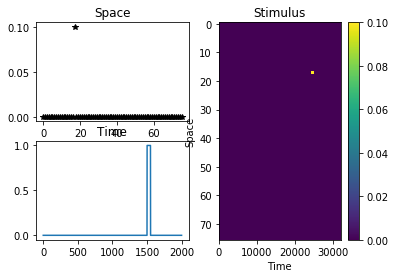

In [28]:
#Configure space and time
stimulus.configure_space()
stimulus.configure_time(numpy.arange(0., 2e3, 2**-4))

#And take a look
plot_pattern(stimulus)

What you should see above are three plots: top-left is the spatial component of the stimuli,
indicating the strength with which the stimuli enters each node; bottom-left is the temporal 
profile for the stimuli; and the colour plot on the right represents the combination of these
two components.

Now we will simulate a region-based simulation with the defined stimulus.

In [33]:
sim = simulator.Simulator(
    model=models.Generic2dOscillator(a=numpy.array(0.3), tau=numpy.array(2)),
    connectivity=white_matter,
    coupling=coupling.Difference(a=numpy.array(7e-4)),
    integrator=integrators.HeunStochastic(dt=0.5, noise=noise.Additive(nsig=numpy.array([5e-5]))),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        ),
    stimulus=stimulus,
    simulation_length=5e3, # 1 minute simulation
).configure()

(tavg_time, tavg_data),  = sim.run()

Let us again plot the results of the simulation as time series.

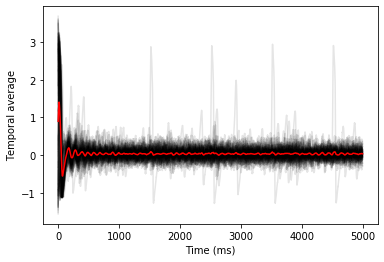

In [34]:
figure()
plot(tavg_time, tavg_data[:, 0, :, 0], 'k', alpha=0.1)
plot(tavg_time, tavg_data[:, 0, :, 0].mean(axis=1), 'r', alpha=1)
ylabel("Temporal average")
xlabel('Time (ms)')
show()

## Visualize the stimulus propagation on the surface brain

In order to get similar plots as in (Spiegler et al., 2016), we need to define a function that visualizes the propagation on the template brain (taken from <a href="https://nbviewer.jupyter.org/urls/s3.amazonaws.com/replicating_spiegler2016/replicating_spiegler2016__html_nb.ipynb">https://nbviewer.jupyter.org/urls/s3.amazonaws.com/replicating_spiegler2016/replicating_spiegler2016__html_nb.ipynb</a>).

In [35]:
#Visualization things - see here https://johngriffiths.github.io/LabNotebook/mpl-surface-viz.html

def plot_surface_mpl(vtx,tri,data=None,rm=None,reorient='tvb',view='superior',
                     shaded=False,ax=None,figsize=(6,4), title=None,
                     lthr=None,uthr=None, nz_thr = 1E-20,
                     shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': None, 'vmax': None}):
                        
  r"""Plot surfaces, surface patterns, and region patterns with matplotlib
    
  This is a general-use function for neuroimaging surface-based data, and 
  does not necessarily require construction of or interaction with tvb 
  datatypes. 

  See also:  plot_surface_mpl_mv



  Parameters
  ----------
  
  vtx           : N vertices x 3 array of surface vertex xyz coordinates 

  tri           : N faces x 3 array of surface faces

  data          : array of numbers to colour surface with. Can be either 
                  a pattern across surface vertices (N vertices x 1 array),
                  or a pattern across the surface's region mapping 
                  (N regions x 1 array), in which case the region mapping 
                  bust also be given as an argument. 
                  
  rm            : region mapping - N vertices x 1 array with (up to) N 
                  regions unique values; each element specifies which 
                  region the corresponding surface vertex is mapped to 

  reorient      : modify the vertex coordinate frame and/or orientation 
                  so that the same default rotations can subsequently be 
                  used for image views. The standard coordinate frame is 
                  xyz; i.e. first,second,third axis = left-right, 
                  front-back, and up-down, respectively. The standard 
                  starting orientation is axial view; i.e. looking down on
                  the brain in the x-y plane.
                  
                  Options: 

                    tvb (default)   : swaps the first 2 axes and applies a rotation
                                              
                    fs              : for the standard freesurfer (RAS) orientation; 
                                      e.g. fsaverage lh.orig. 
                                      No transformations needed for this; so is 
                                      gives same result as reorient=None

  view          : specify viewing angle. 
  
                  This can be done in one of two ways: by specifying a string 
                  corresponding to a standard viewing angle, or by providing 
                  a tuple or list of tuples detailing exact rotations to apply 
                  around each axis. 
                  
                  Standard view options are:
    
                  lh_lat / lh_med / rh_lat / rh_med / 
                  superior / inferior / posterior / anterior

                  (Note: if the surface contains both hemispheres, then medial 
                   surfaces will not be visible, so e.g. 'rh_med' will look the 
                   same as 'lh_lat')
                   
                  Arbitrary rotations can be specied by a tuple or a list of 
                  tuples, each with two elements, the first defining the axis 
                  to rotate around [0,1,2], the second specifying the angle in 
                  degrees. When a list is given the rotations are applied 
                  sequentially in the order given. 
                  
                  Example: rotations = [(0,45),(1,-45)] applies 45 degrees 
                  rotation around the first axis, followed by 45 degrees rotate 
                  around the second axis. 

  lthr/uthr     : lower/upper thresholds - set to zero any datapoints below / 
                  above these values
  
  nz_thr        : near-zero threshold - set to zero all datapoints with absolute 
                  values smaller than this number. Default is a very small 
                  number (1E-20), which unless your data has very small numbers, 
                  will only mask out actual zeros. 

  shade_kwargs  : dictionary specifiying shading options

                  Most relevant options (see matplotlib 'tripcolor' for full details):
                  
                    - 'shading'        (either 'gourand' or omit; 
                                        default is 'flat')
                    - 'edgecolors'     'k' = black is probably best
                    - 'linewidth'      0.1 works well; note that the visual 
                                       effect of this will depend on both the 
                                       surface density and the figure size 
                    - 'cmap'           colormap
                    - 'vmin'/'vmax'    scale colormap to these values
                    - 'alpha'          surface opacity
                  
  ax            : figure axis
  
  figsize       : figure size (ignore if ax provided)
  
  title         : text string to place above figure
  
  
  
                  
  Usage
  -----
       

  Basic freesurfer example:

  import nibabel as nib
  vtx,tri = nib.freesurfer.read_geometry('subjects/fsaverage/surf/lh.orig')
  plot_surface_mpl(vtx,tri,view='lh_lat',reorient='fs')



  Basic tvb example:
  
  ctx = cortex.Cortex.from_file(source_file = ctx_file,
                                region_mapping_file =rm_file)
  vtx,tri,rm = ctx.vertices,ctx.triangles,ctx.region_mapping
  conn = connectivity.Connectivity.from_file(conn_file); conn.configure()
  isrh_reg = conn.is_right_hemisphere(range(conn.number_of_regions))
  isrh_vtx = np.array([isrh_reg[r] for r in rm])
  dat = conn.tract_lengths[:,5]

  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat,view='inferior',title='inferior')

  fig, ax = plt.subplots()
  plot_surface_mpl(vtx=vtx,tri=tri,rm=rm,data=dat, view=[(0,-90),(1,55)],ax=ax,
                   title='lh angle',shade_kwargs={'shading': 'gouraud', 'cmap': 'rainbow'})

   
  """
    
  # Copy things to make sure we don't modify things 
  # in the namespace inadvertently. 
    
  vtx,tri = vtx.copy(),tri.copy()
  if data is not None: data = data.copy()

  # 1. Set the viewing angle 
  
  if reorient == 'tvb':
    # The tvb default brain has coordinates in the order 
    # yxz for some reason. So first change that:   
    vtx = np.array([vtx[:,1],vtx[:,0],vtx[:,2]]).T.copy()
    
    # Also need to reflect in the x axis
    vtx[:,0]*=-1

  # (reorient == 'fs' is same as reorient=None; so not strictly needed
  #  but is included for clarity)
   


  # ...get rotations for standard view options
    
  if   view == 'lh_lat'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'lh_med'    : rots =  [(0,-90),(1,-90) ] 
  elif view == 'rh_lat'    : rots =  [(0,-90),(1,-90) ]
  elif view == 'rh_med'    : rots =  [(0,-90),(1,90)  ]
  elif view == 'superior'  : rots =   None
  elif view == 'inferior'  : rots =   (1,180)
  elif view == 'anterior'  : rots =   (0,-90)
  elif view == 'posterior' : rots =  [(0, -90),(1,180)]
  elif (type(view) == tuple) or (type(view) == list): rots = view 

  # (rh_lat is the default 'view' argument because no rotations are 
  #  for that one; so if no view is specified when the function is called, 
  #  the 'rh_lat' option is chose here and the surface is shown 'as is' 
                            
                            
  # ...apply rotations                          
     
  if rots is None: rotmat = np.eye(3)
  else:            rotmat = get_combined_rotation_matrix(rots)
  vtx = np.dot(vtx,rotmat)

                                    
      
  # 2. Sort out the data
                                    
                                    
  # ...if no data is given, plot a vector of 1s. 
  #    if using region data, create corresponding surface vector 
  if data is None: 
    data = np.ones(vtx.shape[0]) 
  elif data.shape[0] != vtx.shape[0]: 
    data = np.array([data[r] for r in rm])
    
  # ...apply thresholds
  if uthr: data *= (data < uthr)
  if lthr: data *= (data > lthr)
  data *= (np.abs(data) > nz_thr)

                                    
  # 3. Create the surface triangulation object 
  
  x,y,z = vtx.T
  tx,ty,tz = vtx[tri].mean(axis=1).T
  tr = Triangulation(x,y,tri[np.argsort(tz)])
                
  # 4. Make the figure 

  if ax is None: fig, ax = plt.subplots(figsize=figsize)  
  
  #if shade = 'gouraud': shade_opts['shade'] = 
  tc = ax.tripcolor(tr, np.squeeze(data), **shade_kwargs)
                        
  ax.set_aspect('equal')
  ax.axis('off')
    
  if title is not None: ax.set_title(title)
            

def get_combined_rotation_matrix(rotations):
  '''Return a combined rotation matrix from a dictionary of rotations around 
     the x,y,or z axes'''
  rotmat = np.eye(3)
    
  if type(rotations) is tuple: rotations = [rotations] 
  for r in rotations:
    newrot = get_rotation_matrix(r[0],r[1])
    rotmat = np.dot(rotmat,newrot)
  return rotmat


def get_rotation_matrix(rotation_axis, deg):

  '''Return rotation matrix in the x,y,or z plane'''



  # (note make deg minus to change from anticlockwise to clockwise rotation)
  th = -deg * (pi/180) # convert degrees to radians

  if rotation_axis == 0:
    return np.array( [[    1,         0,         0    ],
                      [    0,      cos(th),   -sin(th)],
                      [    0,      sin(th),    cos(th)]])
  elif rotation_axis ==1:
    return np.array( [[   cos(th),    0,        sin(th)],
                      [    0,         1,          0    ],
                      [  -sin(th),    0,        cos(th)]])
  elif rotation_axis ==2:
    return np.array([[   cos(th),  -sin(th),     0    ],
                     [    sin(th),   cos(th),     0   ],
                     [     0,         0,          1   ]])

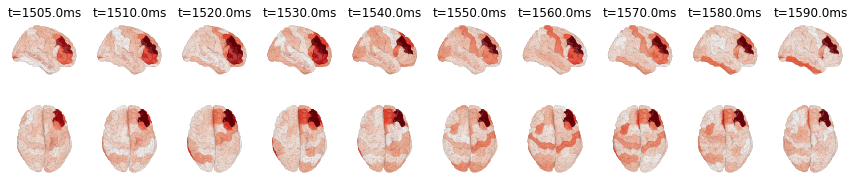

In [36]:
from matplotlib.tri import Triangulation

vtx,tri,rm = default_cortex.vertices,default_cortex.triangles,default_cortex.region_mapping
fig, ax = plt.subplots(ncols=10, nrows=2,figsize=(15,3))
cmap = cm.Reds
cmap.set_under(color='w')

kws = {'edgecolors': 'k', 'vmin': 0.01, 'cmap': cmap, 
       'vmax': 0.6, 'alpha': None, 'linewidth': 0.01}

ts = [1505, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590] 


for t_it,t in enumerate(ts):

  dat = np.absolute(tavg_data[t, 0, :, 0])
    
  plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=rm,ax=ax[0][t_it],
                   shade_kwargs=kws,
                   view='rh_lat')
    
  plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=rm,ax=ax[1][t_it],
                   shade_kwargs=kws,
                   view='superior')
    
    
  ax[0][t_it].set_title('t=%1.1fms' %t)
    

I hope that you see some nice propagation patterns here?!

# Optional additional tasks:

## 1) Stimulate a different area
By selecting another area in your code above, re-run the simulation and look at the brains if the propagation is different?

## 2) Load different data and try out the stimulus


That's all folks -- so, what's next?
------------------------------------

If you're still interested in surface simulations, then we have a number of other tutorials available,
which you might like to check out, on subjects like: defining a custom *LocalConnectivity*. Alternatively, you can get into the details of any aspects 
of TVB simulations that interest you in TVB's hand-book, or the simulator's reference manual (which is
automatically generated from DocStrings within the code)... And, of course, dig into the code itself. 